# Importing libraries and cleaned dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.metrics import pairwise_distances, davies_bouldin_score

import hdbscan

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [2]:
# Importing the cleaned dataset from my first notebook
file_path = '../data/data_cleaned.csv'
df = pd.read_csv(file_path, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

# Filtering the dataset

Based on the initial analysis conducted in previous notebooks, I have made some preliminary decisions regarding data filtering. These decisions include retaining only sales data from the UK and filtering the dataset to include only sales related to products.

In [3]:
# Filtering out the data that are not for products (shipping, bank fees etc)
df_fltrd = df[df.StockCode != 'OTHER']

# Focusing only on clients from UK (they consist 90% of the clients)
# -> At a later stage I could also check adding Germany and France, to refer then to almost 95% of clients
df_fltrd = df_fltrd[df_fltrd.Country == 'United Kingdom']

# Finally, dropping the null values from CustomerID, since the ML model will be based on the different clients
df_fltrd.dropna(subset='CustomerID', inplace=True)

# Creating new column with the total price for each item 
df_fltrd['TotalPrice'] = df_fltrd.Quantity * df_fltrd.UnitPrice

# Feature Engineering

**Total Quantity:** Wholesale customers are likely to purchase larger quantities of items compared to retail customers: using the total quantity purchased by each customer as a feature.

**Total Price:** Wholesale customers typically spend more money on their purchases compared to retail customers: using the total price of orders can help distinguish between the two groups.

**Average Quantity per Item:** Average quantity per item for each customer. Wholesale customers may buy multiples of the same item in a single order, leading to a higher average quantity per item.

**Average Order Value:** The average amount spent per order by each customer. 

**Total Orders:** Wholesale customers are likely to place more orders than retail customers. To calculate the total number of orders for each customer over a given time period. *Not sure if I will use that for the final model.*

For my ML model I will try clustering algorithms such as K-means, DBSCAN, HDBSCAN, or hierarchical clustering. I will do feature engineering, and conduct an EDA to see my data, and experiment and decide on the best model.

In [4]:
# IMPORTANT !!!!!
# after doing the two clusters, to defined with supervised ML, the clients with customerID unknown, to see to which cluster they belong
# so that in the inventory forecast to include these data (it is 1/4 of my data)

# for this case i need to think how to handle the fact that the two cluster will have different amount of samples,
# the retail has wayyy more clients
# should i do some techniques to make the amounts more equal? 

In [5]:
# I will do a function for the feature engineering and the consrtucted dataframe, 
# cause I will use it more than once as exploration

def feat_eng(df):
    #Total quantity purchased
    cust = df.groupby('CustomerID')['Quantity'].sum().reset_index().rename(columns={'Quantity': 'TotalQuantity'})

    # Total value of orders
    cust = pd.merge(cust, df.groupby('CustomerID')['TotalPrice'].sum().reset_index().rename(columns={'TotalPrice': 'TotalValue'}), 
                                                                                       how='left', on='CustomerID')

    # Average quantity per item per order
    # Grouping by StockCode, in case in the same invoice client has added the product more than once
    item_quant = df.groupby(['CustomerID','InvoiceNo','StockCode'])['Quantity'].sum().reset_index()

    cust = pd.merge(cust, item_quant.groupby('CustomerID')['Quantity'].mean().round(2).reset_index().rename(columns={'Quantity':'AvrgQuantity'}), 
                                                                                       how='left', on='CustomerID')

    # Average value per order
    order_val = df.groupby(['CustomerID','InvoiceNo'])['TotalPrice'].sum().reset_index()
    avrg_val = order_val.groupby('CustomerID')['TotalPrice'].mean().round(2).reset_index().rename(columns={'TotalPrice':'AvrgOrderValue'})

    cust = pd.merge(cust, avrg_val, how='left', on='CustomerID')

    # Total orders number
    cust = pd.merge(cust, df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'TotalOrders'}), 
                                                                                       how='left', on='CustomerID')

    # Setting CustomerID as index
    cust.set_index('CustomerID', inplace=True)

    return cust

In [6]:
cust = feat_eng(df_fltrd)
cust.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,TotalOrders
CustomerID,,,,,
12346,74215,92768.75,74215.00,92768.75,1
12747,1275,4722.51,12.38,429.32,11
12748,25051,46021.25,5.87,223.40,206
12749,1470,4043.94,7.42,808.79,5
12820,722,938.94,12.24,234.74,4


# EDA

Based on the following analyis I see that I have many outliers and noise in my data. These are the conclusions drawn from this 'EDA' section:

There is an important decision to be made. I see that I have two types of outliers/ noise.
- One comes from the two invoices with number '581483','541431' (two outliers). The Quantity and value of these invoices is huge, not comparable at all with the rest of the 19962 invoices. Also, these 2 invoices, one is from a client that ordered only once (that very big order of only one item) and the other client had this huge order and only two more items at another time. That makes me think that they are not really repeated wholesale customers, and are stand-alone cases that since they differ so much for the model accuracy can be disadvantage.
- Then when I see my data without these two, I can see the noise around my data. This second type of outliers they still need to be treated, but their scale is more comparable to the rest of the data.

I am going to do outlier clipping for the noise at my data, but when I do it without removing the 2 outliers first, the dataset is still very noisy and I don't trust that the trained ML model can be accurate enough.
For that reason I decided in the next section of the notebook 'Outliers' to treat these two types differently.

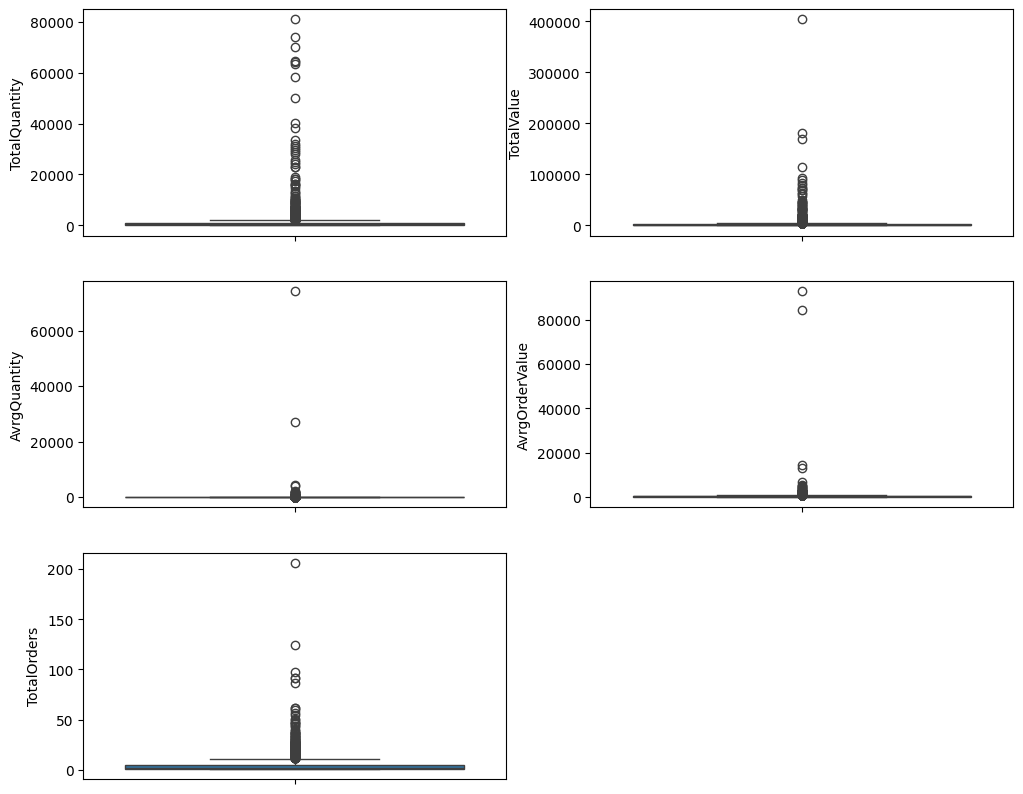

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

sns.boxplot(data=cust['TotalQuantity'], ax=ax[0, 0]) 
sns.boxplot(data=cust['TotalValue'], ax=ax[0, 1]) 
sns.boxplot(data=cust['AvrgQuantity'], ax=ax[1, 0]) 
sns.boxplot(data=cust['AvrgOrderValue'], ax=ax[1, 1]) 
sns.boxplot(data=cust['TotalOrders'], ax=ax[2, 0]) 

# Remove the empty subplot
fig.delaxes(ax[2, 1])

plt.show()

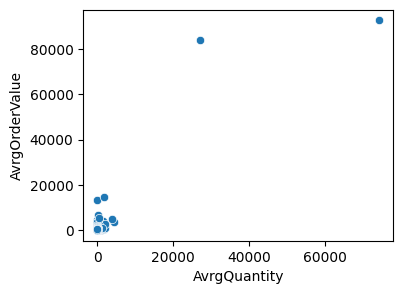

In [8]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust, x='AvrgQuantity', y='AvrgOrderValue')
plt.show()

In [9]:
# Looking into the two big outliers
df[df.InvoiceNo.isin(['581483','541431'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
59649,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.25,12346,United Kingdom
523406,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


In [10]:
df[df.CustomerID.isin([12346,16446])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
59649,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.25,12346,United Kingdom
188029,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18 09:52:00,1.65,16446,United Kingdom
188030,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18 09:52:00,1.25,16446,United Kingdom
523406,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom


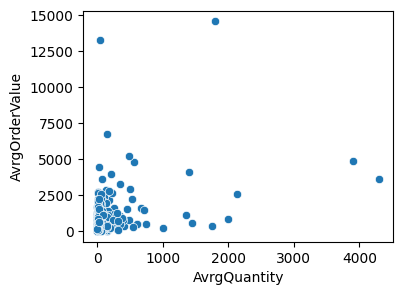

In [11]:
# Checking the scatterplots without the two big outliers, to see my data a bit more clearly
# I am doing he same process as above, using the function I defined
cust_fltrd = feat_eng(df_fltrd[~df_fltrd.InvoiceNo.isin(['581483','541431'])])

# Plotting
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_fltrd, x='AvrgQuantity', y='AvrgOrderValue')
plt.show()

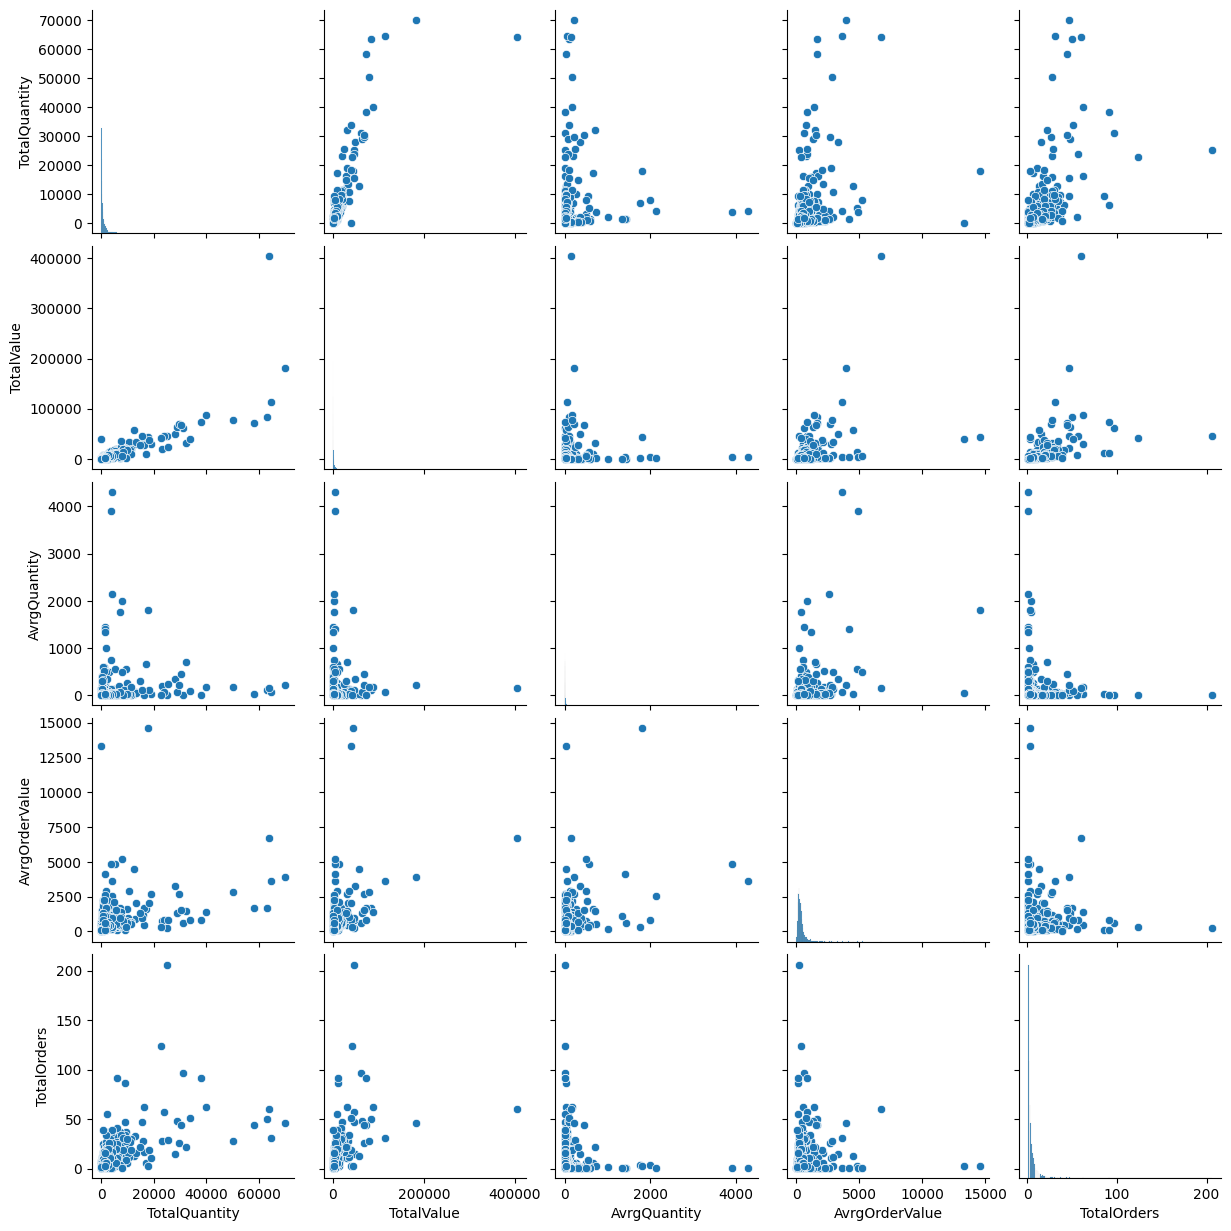

In [12]:
sns.pairplot(cust_fltrd)

# Outliers: data normalization

Based on the noise and outliers that I identified in the previous section, I am going to implement two different approaches for the two types of outliers.
- to the two outliers with the huge difference in scale, I am going to do scaling to a range, scaling them to highest next value (after these two).
- then after completing that, I will do outlier clipping for the rest of the outliers/ noice. I trust that in this way my model will have better scale and will have more accuracy, and at the same time, since I only want two clusters (wholesale and retail) these outliers/noise will still be the highest values in my dataset, and they will most probably be incorporated into the cluster of the wholesale customers. For that I will use the Stardard Deciation method, by z-score to +-3σ (σ is the standard deviation).

Helpful aricle:
https://developers.google.com/machine-learning/data-prep/transform/normalization#:~:text=Z%2Dscore%20is%20a%20variation,extreme%20that%20you%20need%20clipping.

In [13]:
# scaling within a range, updating the Quantity and accordingly the TotalPrice
df_fltrd.loc[df_fltrd.InvoiceNo.isin(['581483','541431']),'Quantity'] = df_fltrd.Quantity.sort_values(ascending=False).values[2]
df_fltrd.loc[df_fltrd.InvoiceNo.isin(['581483','541431']),'TotalPrice'] = df_fltrd.Quantity * df_fltrd.UnitPrice

In [14]:
# Creating the updated customer dataframe
cust_norm = feat_eng(df_fltrd)

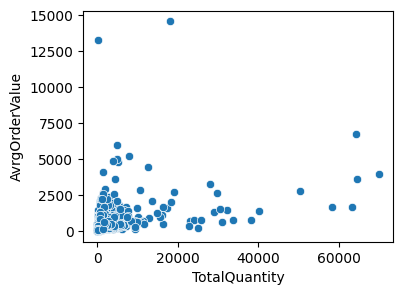

In [15]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_norm, x='TotalQuantity', y='AvrgOrderValue')
plt.show()

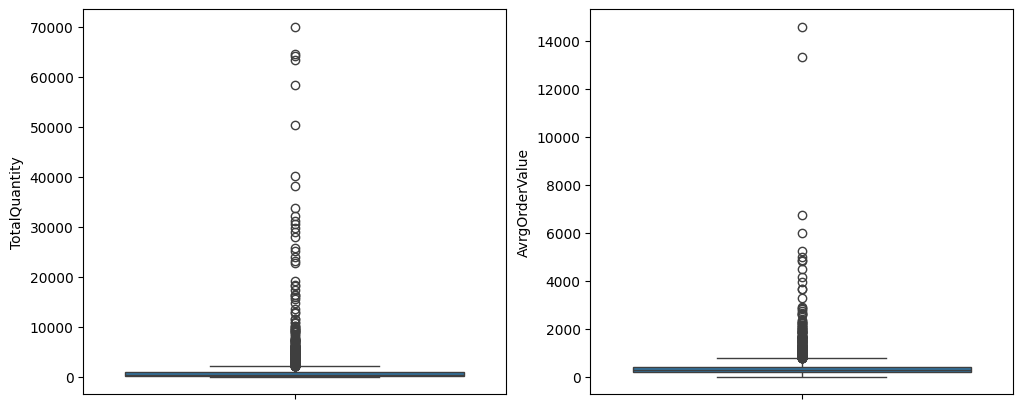

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(data=cust_norm['TotalQuantity'], ax=ax[0]) 
sns.boxplot(data=cust_norm['AvrgOrderValue'], ax=ax[1]) 

plt.show()

In [17]:
cust_norm.columns

Index(['TotalQuantity', 'TotalValue', 'AvrgQuantity', 'AvrgOrderValue',
       'TotalOrders'],
      dtype='object')

In [18]:
cust_norm_clip = cust_norm.copy()

In [19]:
# I will find the Upper limit with the standard deviation method
# I don't have lower limit, cause everything start from 0
tq_UpperLimit = (cust_norm_clip['TotalQuantity'].mean() + cust_norm_clip['TotalQuantity'].std()*3).round(0).astype(int)
tv_UpperLimit = (cust_norm_clip['TotalValue'].mean() + cust_norm_clip['TotalValue'].std()*3).round(2)
av_UpperLimit = (cust_norm_clip['AvrgQuantity'].mean() + cust_norm_clip['AvrgQuantity'].std()*3).round(2)
aov_UpperLimit = (cust_norm_clip['AvrgOrderValue'].mean() + cust_norm_clip['AvrgOrderValue'].std()*3).round(2)
to_UpperLimit = (cust_norm_clip['TotalOrders'].mean() + cust_norm_clip['TotalOrders'].std()*3).round(0).astype(int)

In [20]:
# Chekcing how many outliers there are that fit these requirements
cust_norm_clip[cust_norm_clip['TotalQuantity'] > tq_UpperLimit].shape[0] # 34 instances
cust_norm_clip[cust_norm_clip['TotalValue'] > tv_UpperLimit].shape[0] # 32 instances
cust_norm_clip[cust_norm_clip['AvrgQuantity'] > av_UpperLimit].shape[0] # 23 instances
cust_norm_clip[cust_norm_clip['AvrgOrderValue'] > aov_UpperLimit].shape[0] # 44 instances
cust_norm_clip[cust_norm_clip['TotalOrders'] > to_UpperLimit].shape[0] # 50 instances, more outliers

50

In [21]:
# from domain knowledge I was debating if to do total orders. Given also the outliers, I will not use it
cust_norm_clip.drop('TotalOrders',axis=1,inplace=True)

In [22]:
# Clipping the data
cust_norm_clip.loc[cust_norm_clip['TotalQuantity'] > tq_UpperLimit , 'TotalQuantity'] = tq_UpperLimit
cust_norm_clip.loc[cust_norm_clip['TotalValue'] > tv_UpperLimit , 'TotalValue'] = tv_UpperLimit
cust_norm_clip.loc[cust_norm_clip['AvrgQuantity'] > av_UpperLimit , 'AvrgQuantity'] = av_UpperLimit
cust_norm_clip.loc[cust_norm_clip['AvrgOrderValue'] > aov_UpperLimit , 'AvrgOrderValue'] = aov_UpperLimit

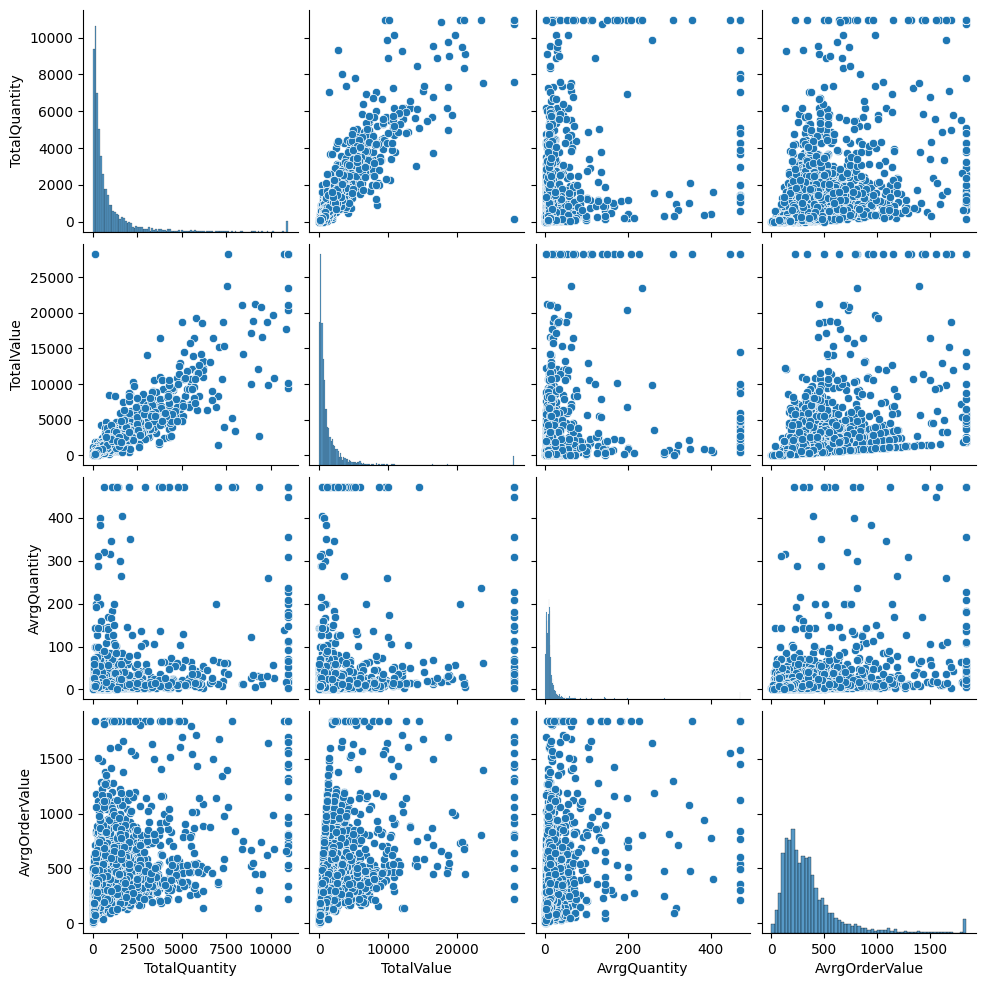

In [23]:
sns.pairplot(cust_norm_clip)

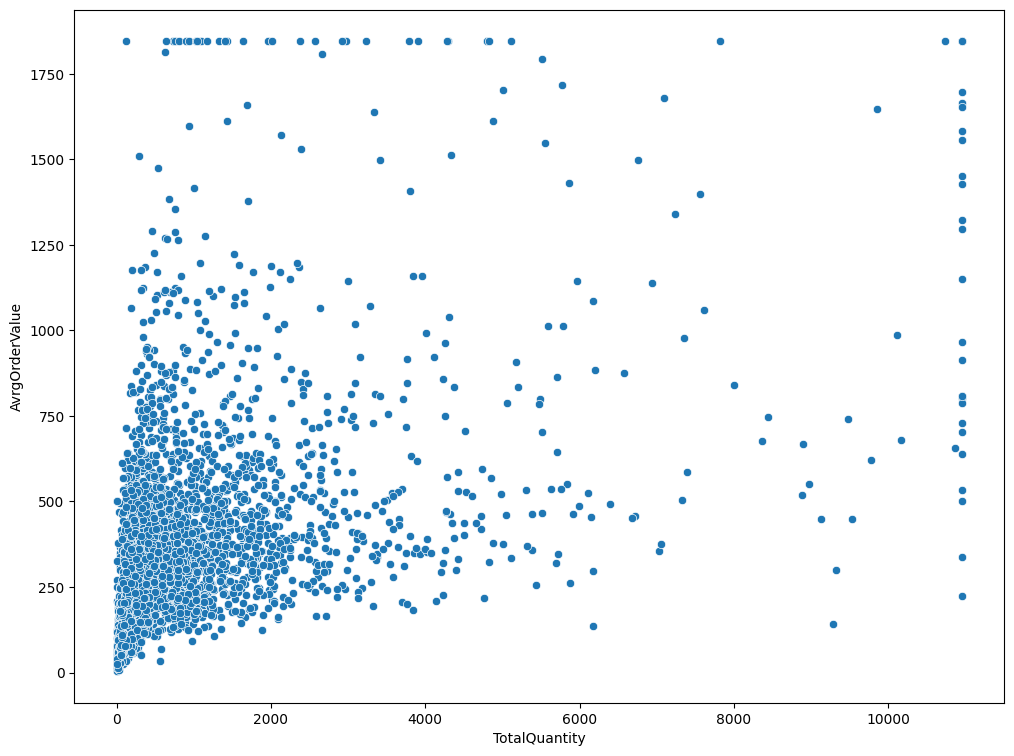

In [24]:
plt.figure(figsize=(12, 9)) 
sns.scatterplot(data=cust_norm_clip, x='TotalQuantity', y='AvrgOrderValue')
plt.show()

# Scaling data

Normalization rescales the data to have values between 0 and 1, while standardization rescales the data to have a mean of 0 and a standard deviation of 1. There are various methods to normalize or standardize the data, such as min-max scaling, z-score scaling, or log transformation. Here I tried the first two, but I will choose the standardization (z-score scaling) that is less sensitive to outliers than min-max scaling (where scale is heavily influenced by the extreme maximum and minimum values).

### Min-Mix Scaler

**Normalization:** in this case, the values are transformed in such a way that the final values will be in the range [0,1].
$$z = \frac{x-min(x)}{(max(x)-min(x))}$$
*In the end I am not using that.*

In [25]:
'''
# Creating an instance of the class MinMaxScaler normalizer
normalizer = MinMaxScaler()

normalizer.fit(cust)

# applying the transformation
cust_norm = normalizer.transform(cust)

cust_norm = pd.DataFrame(cust_norm, columns = cust.columns, index=cust.index)
'''

'\n# Creating an instance of the class MinMaxScaler normalizer\nnormalizer = MinMaxScaler()\n\nnormalizer.fit(cust)\n\n# applying the transformation\ncust_norm = normalizer.transform(cust)\n\ncust_norm = pd.DataFrame(cust_norm, columns = cust.columns, index=cust.index)\n'

### StandardScaler

Standarization: the values are transfomed to end up with mean = 0 and std = 0.

$$z = \frac{(x-mean(x))}{\sigma}$$

In [26]:
# Scaling the data
scaler = StandardScaler()

scaler.fit(cust_norm_clip)

# applying the transformation
cust_norm_clip_stndrd = scaler.transform(cust_norm_clip)

cust_norm_clip_stndrd = pd.DataFrame(cust_norm_clip_stndrd, columns = cust_norm_clip.columns, index=cust_norm_clip.index)
cust_norm_clip_stndrd.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue
CustomerID,,,,
12346,2.575901,1.312867,10.005464,5.154360
12747,0.256937,0.927293,-0.132466,0.255785
12748,6.626359,8.035051,-0.276287,-0.456589
12749,0.385220,0.722486,-0.242043,1.568550
12820,-0.106861,-0.214669,-0.135559,-0.417358


# Elbow Method, for the optimal number of clusters

Ideally I want to make 2 clusters, one for wholesale and one for retail customers.
I am doing the Elbow Method (most commonly used with clustering algorithms like K-means) to see how the inertia looks depending on the number of clusters.

From the result I can see that doing 2 or 4 cluster would be a good option.

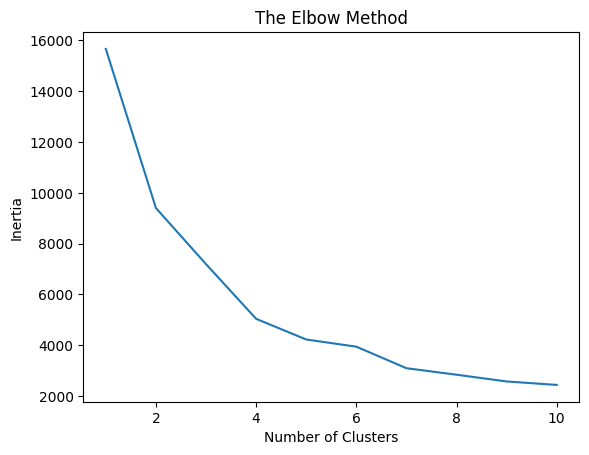

In [27]:
# Finding the optimal number of clusters
inertias = []

# Checking the plot for 1-10 clusters
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cust_norm_clip_stndrd)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# 2 or 4 clusters

# Building models

Helpful resource:
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py

## Clustering with K-Means

After looking at my EDA, I conclude that K-Means will not be a good model for my dataset. I will test it however anywyay.

K-means can be quite sensitive to oultiers and has an intrinsic preference for globular clusters.

In [28]:
# Choosing 4 clusters
kmeans = KMeans(n_clusters=4)

# Using only the two more interesting features
kmeans.fit(cust_norm_clip_stndrd)

cust_kmeans = cust_norm_clip_stndrd.copy()
cust_kmeans['kmeans_4'] = kmeans.labels_
cust_kmeans

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,kmeans_4
CustomerID,,,,,
12346,2.575901,1.312867,10.005464,5.154360,3
12747,0.256937,0.927293,-0.132466,0.255785,2
12748,6.626359,8.035051,-0.276287,-0.456589,1
12749,0.385220,0.722486,-0.242043,1.568550,2
12820,-0.106861,-0.214669,-0.135559,-0.417358,0
...,...,...,...,...,...
18280,-0.552234,-0.443507,-0.306553,-0.604135,0
18281,-0.546313,-0.473668,-0.235637,-0.949840,0
18282,-0.514078,-0.452001,-0.216416,-0.965442,0


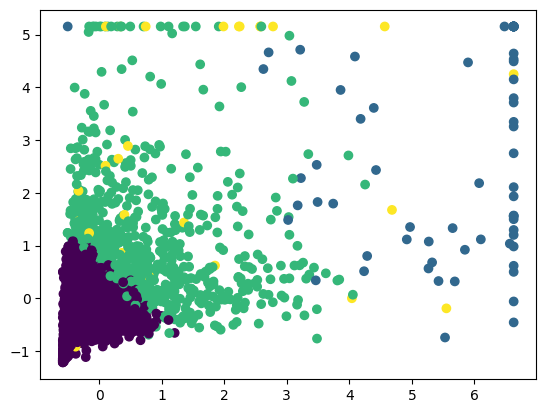

In [29]:
# Plotting the results
plt.scatter(x=cust_kmeans['TotalQuantity'], y=cust_kmeans['AvrgOrderValue'], c=cust_kmeans['kmeans_4'])
plt.show()

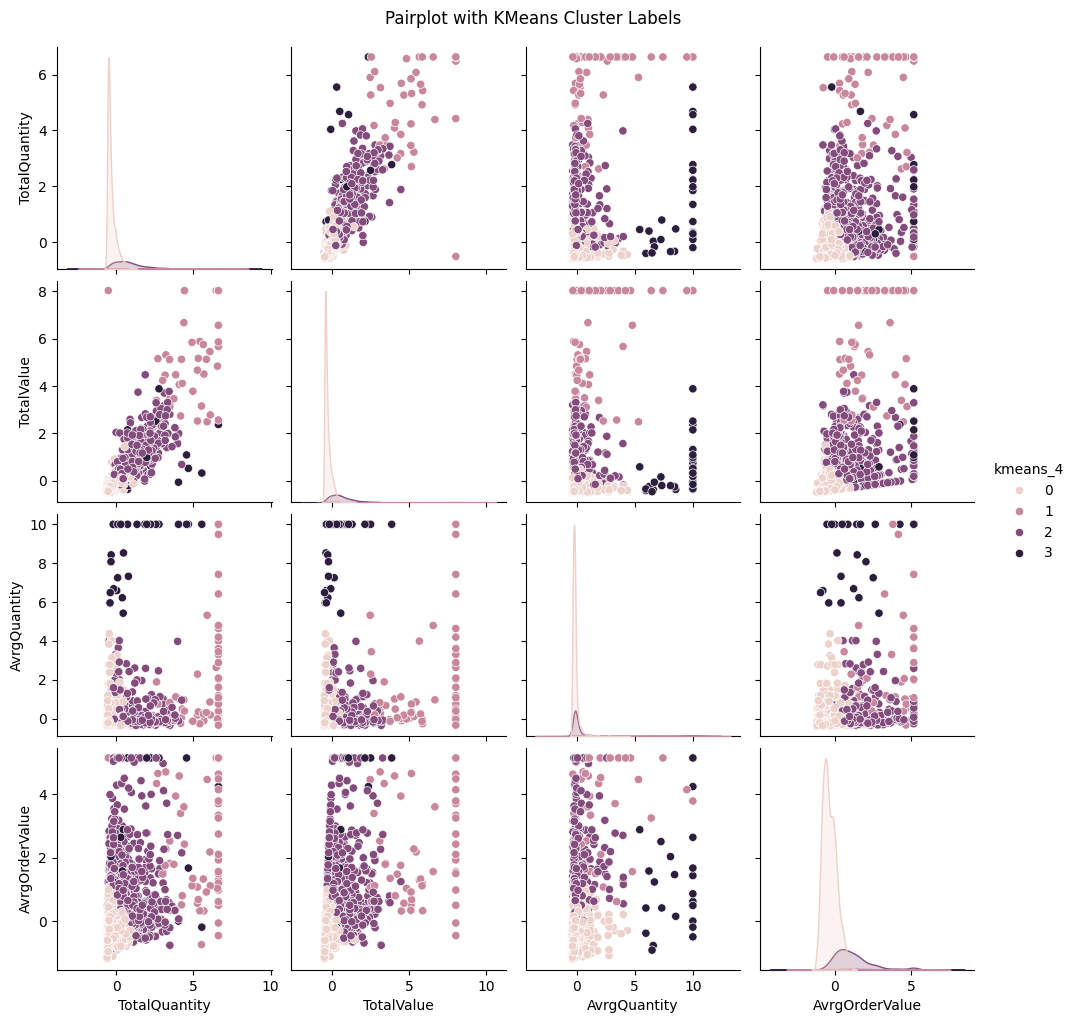

In [30]:
sns.pairplot(cust_kmeans, hue='kmeans_4')
plt.suptitle("Pairplot with KMeans Cluster Labels", y=1.02)
plt.savefig("../images/pairplot_kmeans.png")
plt.show()

### Clustering with K-means - Less fetures

At the conclusion is shown that more features for this model work better.

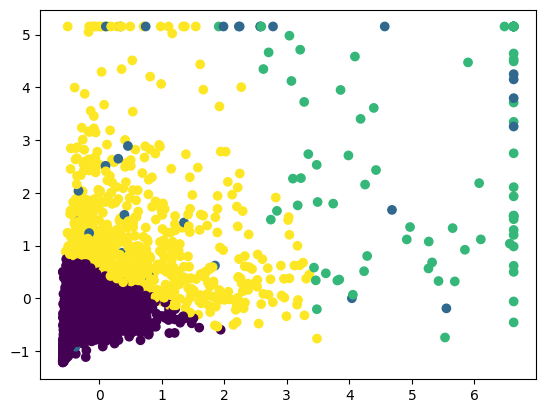

In [31]:
cust_kmeans2 = cust_norm_clip_stndrd[['TotalQuantity','AvrgQuantity','AvrgOrderValue']].copy()

# Choosing 4 clusters
kmeans2 = KMeans(n_clusters=4)

# Using only the two more interesting features
kmeans2.fit(cust_kmeans2)

cust_kmeans2['kmeans_4'] = kmeans2.labels_

# Plotting the results
plt.scatter(x=cust_kmeans2['TotalQuantity'], y=cust_kmeans2['AvrgOrderValue'], c=cust_kmeans2['kmeans_4'])
plt.show()

## Clustering with DBSCAN

A density-based clustering algorithm.

DBSCAN tends to fall short of identifying clusters with non-uniform density.

In [32]:
dbscan = DBSCAN(eps=0.5, min_samples=10)

labels_dbscan = dbscan.fit_predict(cust_norm_clip_stndrd)

np.unique(labels_dbscan)

cust_dbscan = cust_norm_clip_stndrd.copy()
cust_dbscan['dbscan_labels'] = labels_dbscan

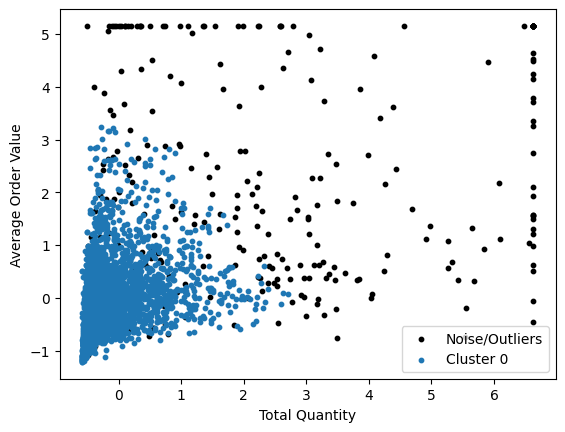

In [33]:
def scatter_plot(df, labels):
    # Define colors for each cluster, now works for until 10 labels
    #cluster_colors = ['blue', 'red', 'green', 'brown', 'pink', 'yellow', 'silver', 'orange', 'purple', 'cyan']
    cluster_colors =sns.color_palette('tab10')

    # Visualising the clusters
    for label in np.unique(labels):
        if label == -1:
            # Plot points labeled as noise/outliers in black
            plt.scatter(df.iloc[labels == label, 0], df.iloc[labels == label, 1], s = 10, color = 'black', label = 'Noise/Outliers')
        else:
            # Plot points for each cluster with different color
            plt.scatter(df.iloc[labels == label, 0], df.iloc[labels == label, 1], s = 10, color = cluster_colors[label], label = f'Cluster {label}')

    plt.xlabel('Total Quantity')
    plt.ylabel('Average Order Value')
    plt.legend()
    plt.show()

    return


scatter_plot(cust_dbscan[['TotalQuantity','AvrgOrderValue']], labels_dbscan)

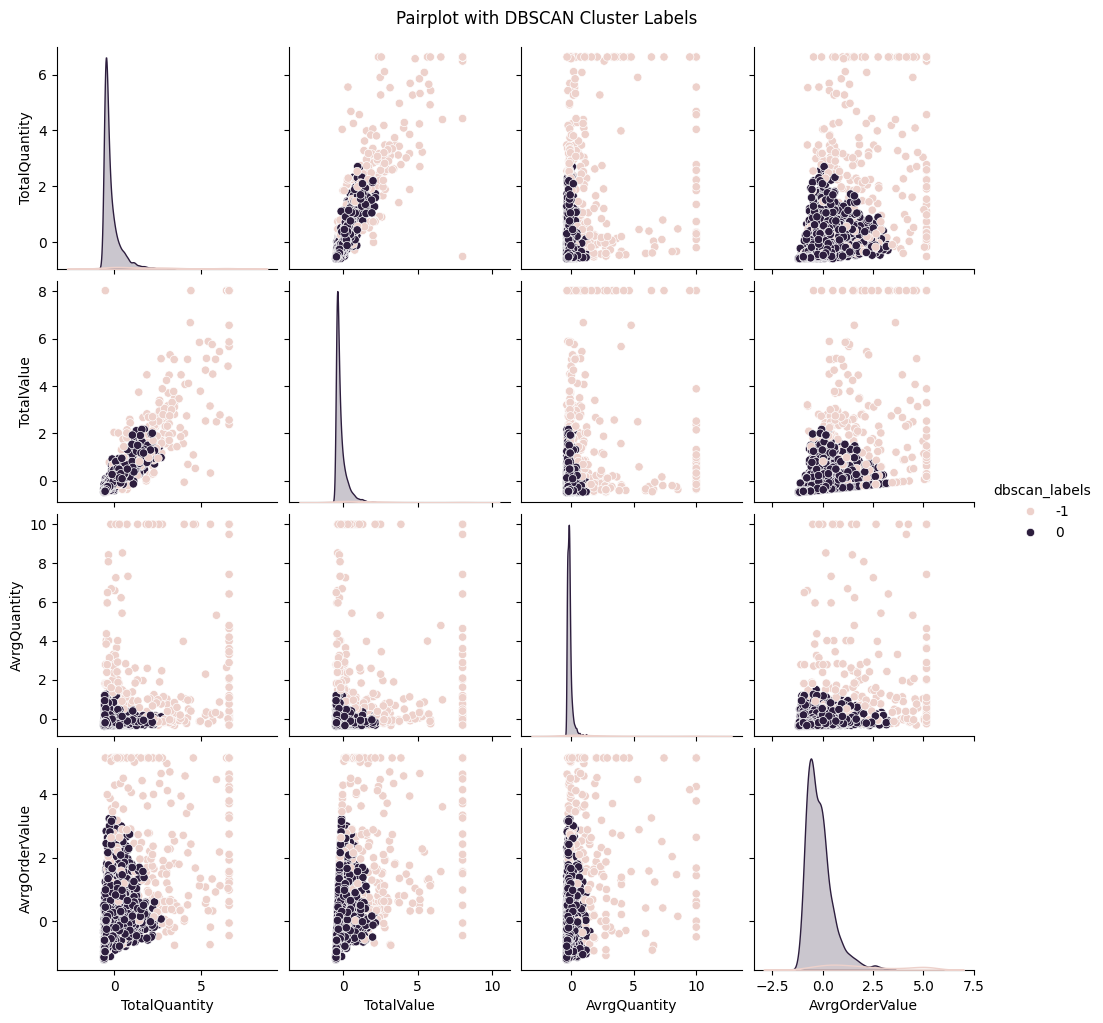

In [59]:
sns.pairplot(cust_dbscan, hue='dbscan_labels')
plt.suptitle("Pairplot with DBSCAN Cluster Labels", y=1.02)
plt.savefig("../images/pairplot_dbscan.png")
plt.show()

### Clustering with DBSCAN - with less features

At the conclusion is shown that more features for this model work better.

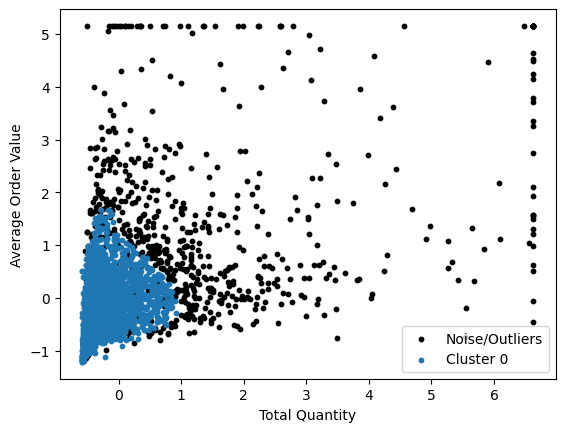

In [35]:
# trying DBSCAN with less features
cust_dbscan2 = cust_norm_clip_stndrd[['TotalQuantity','AvrgQuantity','AvrgOrderValue']].copy()

dbscan2 = DBSCAN(eps=0.2, min_samples=20)

labels_dbscan2 = dbscan2.fit_predict(cust_dbscan2)

np.unique(labels_dbscan2)

cust_dbscan2['dbscan_labels'] = labels_dbscan2

scatter_plot(cust_dbscan2[['TotalQuantity','AvrgOrderValue']], labels_dbscan2)

## Clustering with HDBSCAN

This model doesn't look that good.

In [36]:
# hyperparameters

[-1  0  1  2  3]


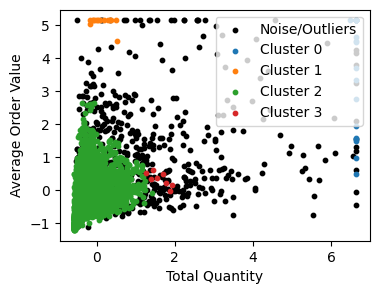

[-1  0  1  2]


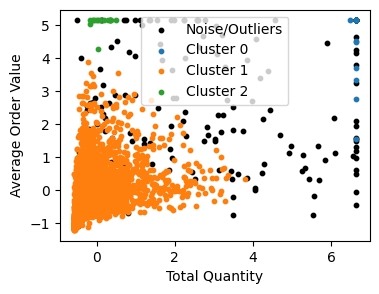

[-1  0  1  2]


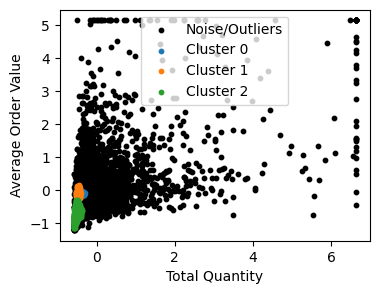

In [37]:
PARAM = ({"min_cluster_size": 8}, {"min_cluster_size": 10}, {"min_cluster_size": 20})
for i, param in enumerate(PARAM):
    hdb = HDBSCAN(**param).fit(cust_norm_clip_stndrd)
    labels = hdb.labels_

    print(np.unique(labels))
    plt.figure(figsize=(4, 3))
    scatter_plot(cust_norm_clip_stndrd[['TotalQuantity','AvrgOrderValue']], labels)
    plt.show()

[-1  0  1  2]


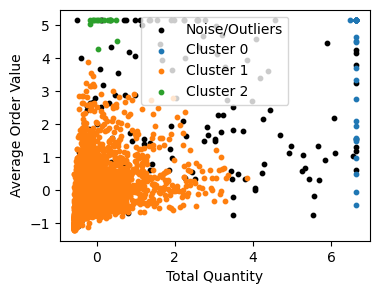

[-1  0  1  2  3]


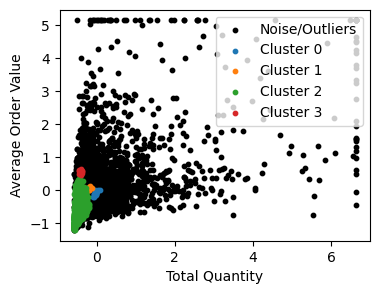

[-1  0  1]


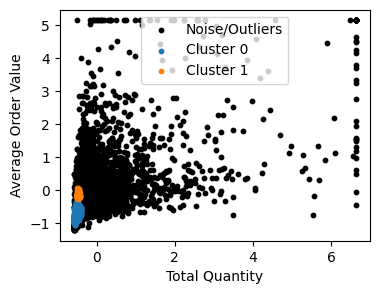

In [38]:
PARAM = (
    {"min_cluster_size": 10, "min_samples": 5},
    {"min_cluster_size": 10, "min_samples": 15},
    {"min_cluster_size": 10, "min_samples": 40},
)

for i, param in enumerate(PARAM):
    hdb = HDBSCAN(**param).fit(cust_norm_clip_stndrd)
    labels = hdb.labels_

    print(np.unique(labels))
    plt.figure(figsize=(4, 3))
    scatter_plot(cust_norm_clip_stndrd[['TotalQuantity','AvrgOrderValue']], labels)
    plt.show()

[-1  0  1  2]


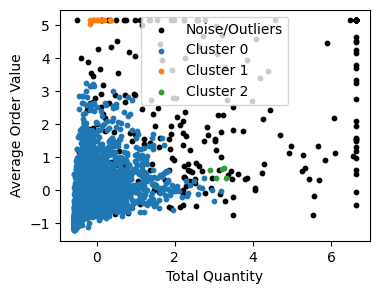

[-1  0]


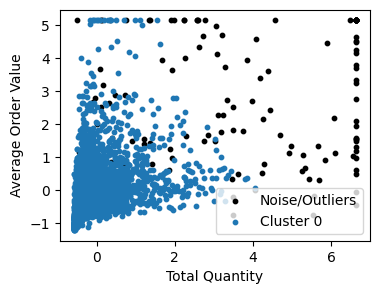

[-1  0  1  2]


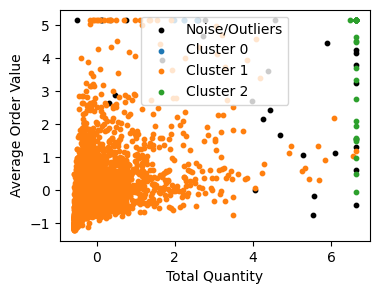

In [39]:
PARAM = (
    {"cut_distance": 0.5},
    {"cut_distance": 1},
    {"cut_distance": 2},
)
hdb = HDBSCAN()
hdb.fit(cust_norm_clip_stndrd)

for i, param in enumerate(PARAM):
    labels = hdb.dbscan_clustering(**param)

    print(np.unique(labels))
    plt.figure(figsize=(4, 3))
    scatter_plot(cust_norm_clip_stndrd[['TotalQuantity','AvrgOrderValue']], labels)
    plt.show()

[-1  0  1  2]


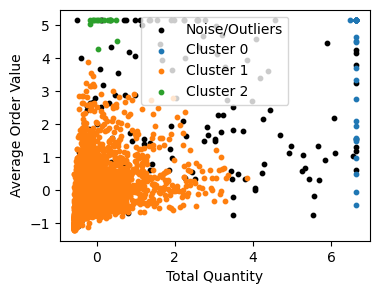

In [40]:
# I choose from the aboves the parameters that look best
hdb = HDBSCAN(min_cluster_size= 10, min_samples= 5).fit(cust_norm_clip_stndrd)
hdb_labels = hdb.labels_

cust_hdbscan = cust_norm_clip_stndrd.copy()
cust_hdbscan['hdbscan_labels'] = hdb_labels

print(np.unique(hdb_labels))
plt.figure(figsize=(4, 3))
scatter_plot(cust_hdbscan[['TotalQuantity','AvrgOrderValue']], hdb_labels)
plt.show(0)

## Gaussian Mixture clustering

At the conclusion is shown that less features for this model work better. See next section: Gaussian Mixture clustering - Less features

In [41]:
gm = GaussianMixture(n_components=4).fit(cust_norm_clip_stndrd)

cust_gm = cust_norm_clip_stndrd.copy()
cust_gm['gm_4'] = gm.predict(cust_norm_clip_stndrd)

cust_gm.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,gm_4
CustomerID,,,,,
12346,2.575901,1.312867,10.005464,5.154360,3
12747,0.256937,0.927293,-0.132466,0.255785,1
12748,6.626359,8.035051,-0.276287,-0.456589,1
12749,0.385220,0.722486,-0.242043,1.568550,2
12820,-0.106861,-0.214669,-0.135559,-0.417358,2


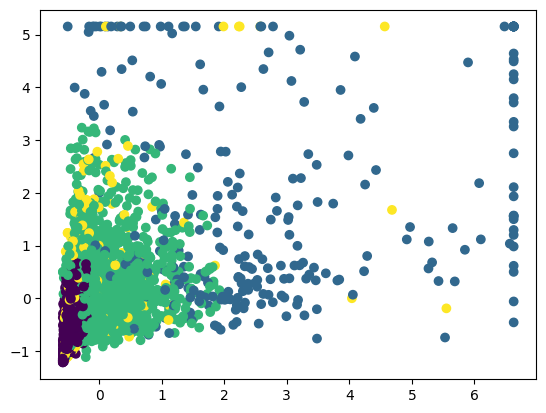

In [42]:
plt.scatter(x=cust_gm['TotalQuantity'], y=cust_gm['AvrgOrderValue'], c=cust_gm['gm_4'])
plt.show()

### Gaussian Mixture clustering - Less features

This specific model does work better with less features.

In [43]:
cust_gm2 = cust_norm_clip_stndrd[['TotalQuantity','AvrgQuantity','AvrgOrderValue']].copy()

gm2 = GaussianMixture(n_components=4).fit(cust_gm2)

cust_gm2['gm_4'] = gm2.predict(cust_gm2)

cust_gm2.head()

,TotalQuantity,AvrgQuantity,AvrgOrderValue,gm_4
CustomerID,,,,
12346,2.575901,10.005464,5.154360,2
12747,0.256937,-0.132466,0.255785,0
12748,6.626359,-0.276287,-0.456589,2
12749,0.385220,-0.242043,1.568550,3
12820,-0.106861,-0.135559,-0.417358,0


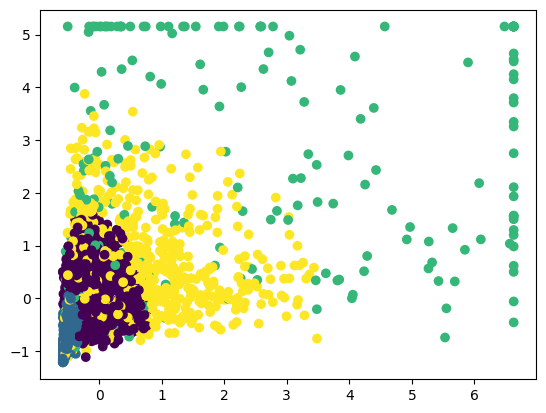

In [44]:
plt.scatter(x=cust_gm2['TotalQuantity'], y=cust_gm2['AvrgOrderValue'], c=cust_gm2['gm_4'])
plt.show()

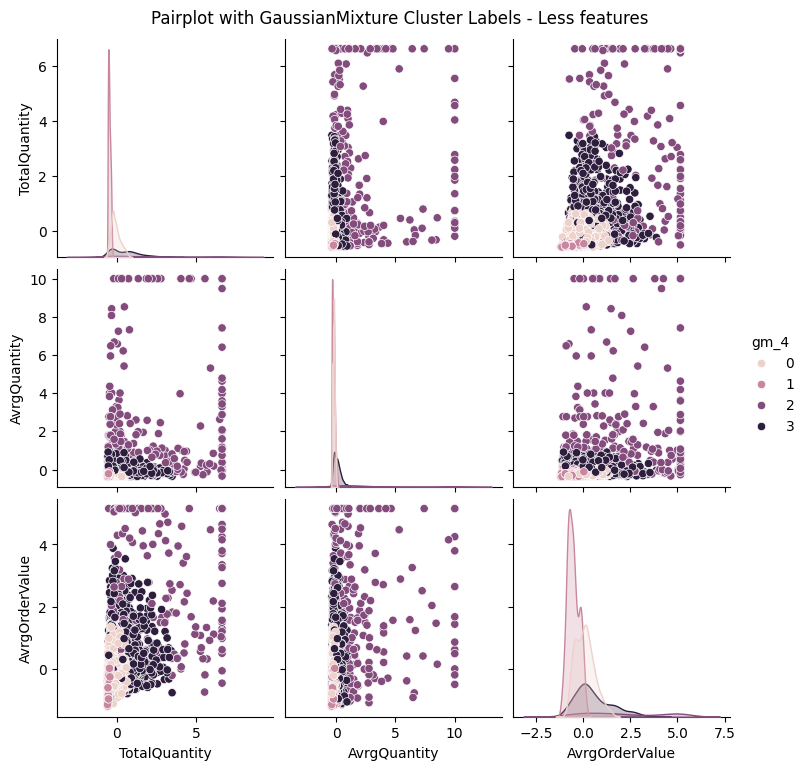

In [45]:
sns.pairplot(cust_gm2, hue='gm_4')
plt.suptitle("Pairplot with GaussianMixture Cluster Labels - Less features", y=1.02)
plt.savefig("../images/pairplot_gm2.png")
plt.show()

## Mean shift clustering

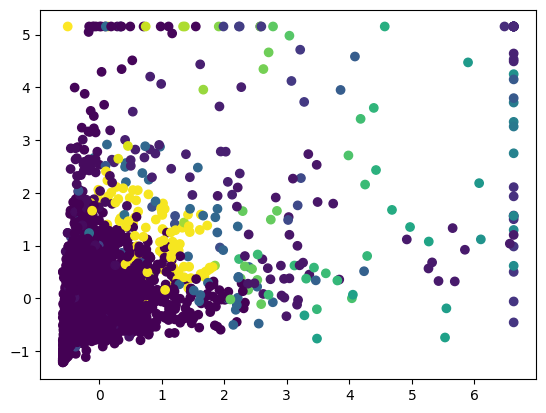

In [46]:
cust_mshift = cust_norm_clip_stndrd.copy()

mshclust = MeanShift().fit(cust_mshift)

cust_mshift['mshift'] = mshclust.labels_

plt.scatter(x=cust_mshift['TotalQuantity'], y=cust_mshift['AvrgOrderValue'], c=cust_mshift['mshift'])
plt.show()

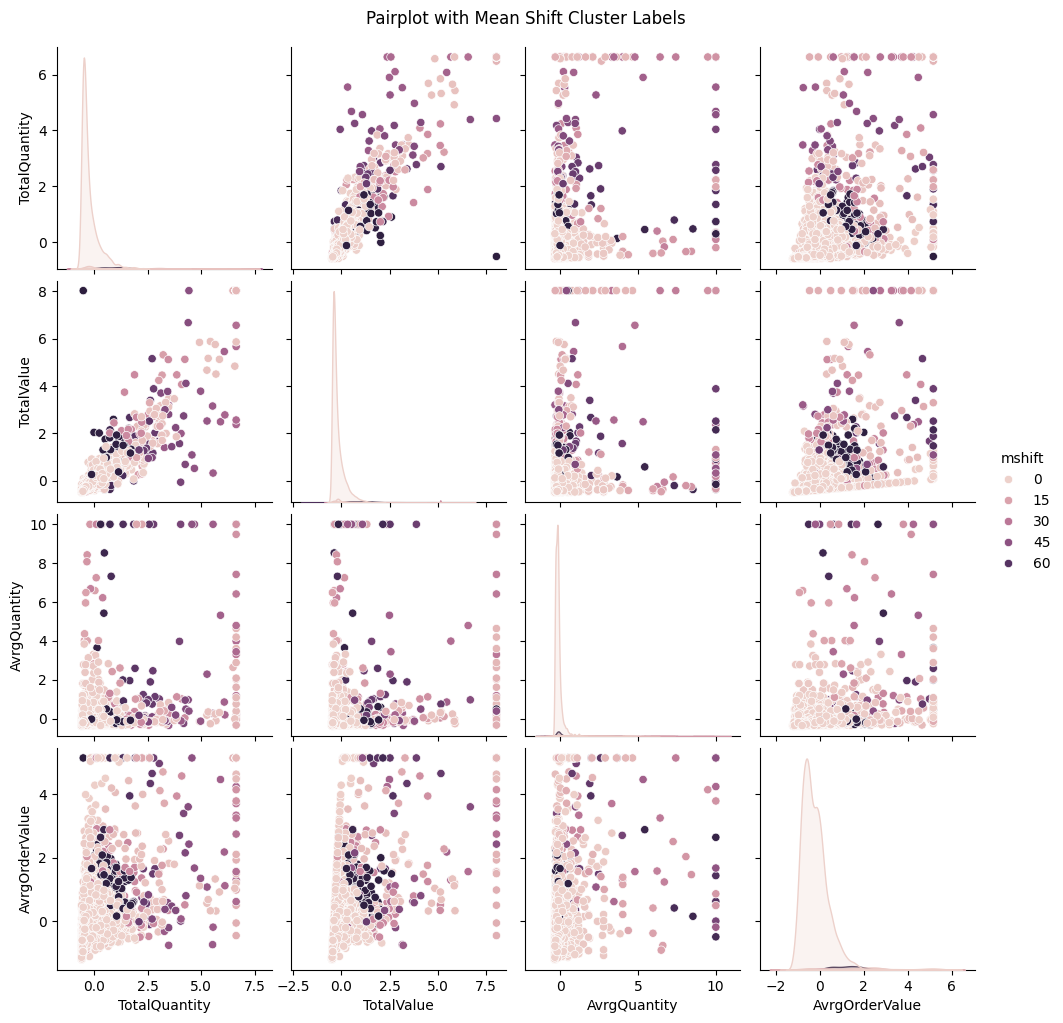

In [47]:
sns.pairplot(cust_mshift, hue='mshift')
plt.suptitle("Pairplot with Mean Shift Cluster Labels", y=1.02)
plt.savefig("../images/pairplot_meanshift.png")
plt.show()

### Mean shift clustering - Less features

At the conclusion is shown that more features for this model work better.

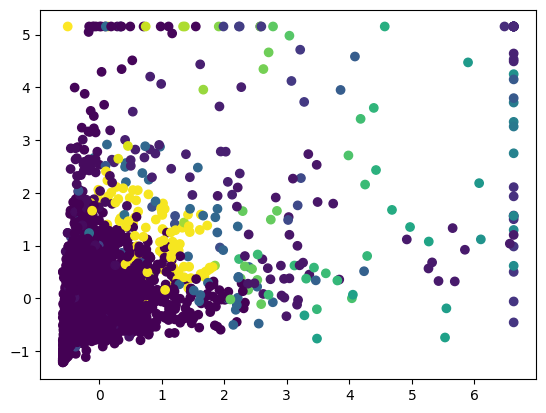

In [48]:
cust_mshift2 = cust_norm_clip_stndrd[['TotalQuantity','AvrgQuantity','AvrgOrderValue']].copy()

mshclust2 = MeanShift().fit(cust_mshift2)

cust_mshift2['mshift'] = mshclust.labels_

plt.scatter(x=cust_mshift2['TotalQuantity'], y=cust_mshift2['AvrgOrderValue'], c=cust_mshift2['mshift'])
plt.show()

# Model evaluation

Visual inspection has also been done, comparing the pairplots for the 4 models.

Helpful resource: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

In [49]:
cust_kmeans.head(2)

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,kmeans_4
CustomerID,,,,,
12346,2.575901,1.312867,10.005464,5.154360,3
12747,0.256937,0.927293,-0.132466,0.255785,2


In [50]:
cust_dbscan.head(2)

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,dbscan_labels
CustomerID,,,,,
12346,2.575901,1.312867,10.005464,5.154360,-1
12747,0.256937,0.927293,-0.132466,0.255785,0


In [51]:
cust_hdbscan.head(2)

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,hdbscan_labels
CustomerID,,,,,
12346,2.575901,1.312867,10.005464,5.154360,-1
12747,0.256937,0.927293,-0.132466,0.255785,1


In [52]:
cust_gm.head(2)

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,gm_4
CustomerID,,,,,
12346,2.575901,1.312867,10.005464,5.154360,3
12747,0.256937,0.927293,-0.132466,0.255785,1


In [53]:
cust_mshift.head(2)

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,mshift
CustomerID,,,,,
12346,2.575901,1.312867,10.005464,5.154360,13
12747,0.256937,0.927293,-0.132466,0.255785,0


## Silhouette Coefficient

- The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. Scores around zero indicate overlapping clusters.
- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
- The Silhouette Coefficient is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [54]:
print(f"Kmeans silhouette coefficient: {metrics.silhouette_score(cust_kmeans, cust_kmeans['kmeans_4'], metric='euclidean')}")
print(f"Kmeans-LessFeatures silhouette coefficient: {metrics.silhouette_score(cust_kmeans2, cust_kmeans2['kmeans_4'], metric='euclidean')}")
print("")
print(f"DBSCAN silhouette coefficient: {metrics.silhouette_score(cust_dbscan, cust_dbscan['dbscan_labels'], metric='euclidean')}")
print(f"DBSCAN-LessFeatures silhouette coefficient: {metrics.silhouette_score(cust_dbscan2, cust_dbscan2['dbscan_labels'], metric='euclidean')}")
print("")
print(f"HDBSCAN silhouette coefficient: {metrics.silhouette_score(cust_hdbscan, cust_hdbscan['hdbscan_labels'], metric='euclidean')}")
print("")
print(f"GaussianMixture silhouette coefficient: {metrics.silhouette_score(cust_gm, cust_gm['gm_4'], metric='euclidean')}")
print(f"GaussianMixture-LessFeatures silhouette coefficient: {metrics.silhouette_score(cust_gm2, cust_gm2['gm_4'], metric='euclidean')}")
print("")
print(f"MeanShift silhouette coefficient: {metrics.silhouette_score(cust_mshift, cust_mshift['mshift'], metric='euclidean')}")
print(f"MeanShift-LessFeatures silhouette coefficient: {metrics.silhouette_score(cust_mshift2, cust_mshift2['mshift'], metric='euclidean')}")

Kmeans silhouette coefficient: 0.6787005978104956
Kmeans-LessFeatures silhouette coefficient: 0.7456877730653068

DBSCAN silhouette coefficient: 0.7437620394715588
DBSCAN-LessFeatures silhouette coefficient: 0.6026343144934078

HDBSCAN silhouette coefficient: 0.7312014139029822

GaussianMixture silhouette coefficient: 0.584461942678694
GaussianMixture-LessFeatures silhouette coefficient: 0.5152601980071299

MeanShift silhouette coefficient: 0.6959797122085571
MeanShift-LessFeatures silhouette coefficient: 0.7142956982129238


## Calinski-Harabasz Index

- The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
- The score is fast to compute.
- The Calinski-Harabasz index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained through DBSCAN.

In [55]:
print(f"Kmeans Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_kmeans, cust_kmeans['kmeans_4'])}")
print(f"Kmeans-LessFeatures Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_kmeans2, cust_kmeans2['kmeans_4'])}")
print("")
print(f"DBSCAN Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_dbscan, cust_dbscan['dbscan_labels'])}")
print(f"DBSCAN-LessFeatures Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_dbscan2, cust_dbscan2['dbscan_labels'])}")
print("")
print(f"HDBSCAN Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_hdbscan, cust_hdbscan['hdbscan_labels'])}")
print("")
print(f"GaussianMixture Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_gm, cust_gm['gm_4'])}")
print(f"GaussianMixture-LessFeatures Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_gm2, cust_gm2['gm_4'])}")
print("")
print(f"MeanShift Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_mshift, cust_mshift['mshift'])}")
print(f"MeanShift-LessFeatures Calinski-Harabasz Index: {metrics.calinski_harabasz_score(cust_mshift2, cust_mshift2['mshift'])}")

Kmeans Calinski-Harabasz Index: 3392.783127630024
Kmeans-LessFeatures Calinski-Harabasz Index: 4441.091739118907

DBSCAN Calinski-Harabasz Index: 2138.0466036001717
DBSCAN-LessFeatures Calinski-Harabasz Index: 1773.3523072031228

HDBSCAN Calinski-Harabasz Index: 1256.1367233726573

GaussianMixture Calinski-Harabasz Index: 1764.9796813369687
GaussianMixture-LessFeatures Calinski-Harabasz Index: 1828.3988864624087

MeanShift Calinski-Harabasz Index: 12858.689912262176
MeanShift-LessFeatures Calinski-Harabasz Index: 15411.633220755444


## Davies-Bouldin Index

- Lower Davies-Bouldin index relates to a model with better separation between the clusters
- The computation of Davies-Bouldin is simpler than that of Silhouette scores.
- The index is solely based on quantities and features inherent to the dataset as its computation only uses point-wise distances.
- The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, such as density based clusters like those obtained from DBSCAN.
- The usage of centroid distance limits the distance metric to Euclidean space.

In [56]:
print(f"Kmeans Davies-Bouldin Index: {davies_bouldin_score(cust_kmeans, cust_kmeans['kmeans_4'])}")
print(f"Kmeans-LessFeatures Davies-Bouldin Index: {davies_bouldin_score(cust_kmeans2, cust_kmeans2['kmeans_4'])}")
print("")
print(f"DBSCAN Davies-Bouldin Index: {davies_bouldin_score(cust_dbscan, cust_dbscan['dbscan_labels'])}")
print(f"DBSCAN-LessFeatures Davies-Bouldin Index: {davies_bouldin_score(cust_dbscan2, cust_dbscan2['dbscan_labels'])}")
print("")
print(f"HDBSCAN Davies-Bouldin Index: {davies_bouldin_score(cust_hdbscan, cust_hdbscan['hdbscan_labels'])}")
print("")
print(f"GaussianMixture Davies-Bouldin Index: {davies_bouldin_score(cust_gm, cust_gm['gm_4'])}")
print(f"GaussianMixture-Less Features Davies-Bouldin Index: {davies_bouldin_score(cust_gm2, cust_gm2['gm_4'])}")
print("")
print(f"MeanShift Davies-Bouldin Index: {davies_bouldin_score(cust_mshift, cust_mshift['mshift'])}")
print(f"MeanShift-LessFeatures Davies-Bouldin Index: {davies_bouldin_score(cust_mshift2, cust_mshift2['mshift'])}")

Kmeans Davies-Bouldin Index: 0.7085192869326515
Kmeans-LessFeatures Davies-Bouldin Index: 0.7130701590102658

DBSCAN Davies-Bouldin Index: 1.1390741633945884
DBSCAN-LessFeatures Davies-Bouldin Index: 1.1844138441028582

HDBSCAN Davies-Bouldin Index: 0.9666221475828692

GaussianMixture Davies-Bouldin Index: 1.1430638241271995
GaussianMixture-Less Features Davies-Bouldin Index: 1.266477681018622

MeanShift Davies-Bouldin Index: 0.2824749159057506
MeanShift-LessFeatures Davies-Bouldin Index: 0.2907980475490986


# Conclusions

Firstly, the test scores work the best to compare models of the same type. By looking at these scores, it is evident if the models perform better with more or less features:
- Kmeans: model with **more** features better
- DBSCAN: model with **more** features better
- HDBSCAN (this I didn't check, cause I was not satisfied with the model)
- Gaussian Mixture: model with **less** features better
- Mean Shift: model with **more** features better



After doing the analysis and seeing the results, I conclude:
- firstly that I will opt to not use DBSCAN or HDBSCAN that filter out outliers, cause I actually want to cluster all my data and not exclude some. I could cluster the outleirs on a cluster of their own, but propably it is not the ideal solution for best cluster metrics and characteristic.
- Between K-means and Gaussian Mixture, I see from the evaluation metrics that K-means performs better, so I am going to opt for that.
- Although from visual inspection, the results of Mean Shift did not look good, it has the best scores. 

In [57]:
cust_clust = pd.merge(cust_norm_clip, cust_kmeans['kmeans_4'], left_index=True, right_index=True)
cust_clust.rename(columns={'kmeans_4':'Labels'}, inplace=True)
cust_clust.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue,Labels
CustomerID,,,,,
12346,4800,6000.00,471.27,1845.31,3
12747,1275,4722.51,12.38,429.32,2
12748,10957,28272.06,5.87,223.40,1
12749,1470,4043.94,7.42,808.79,2
12820,722,938.94,12.24,234.74,0


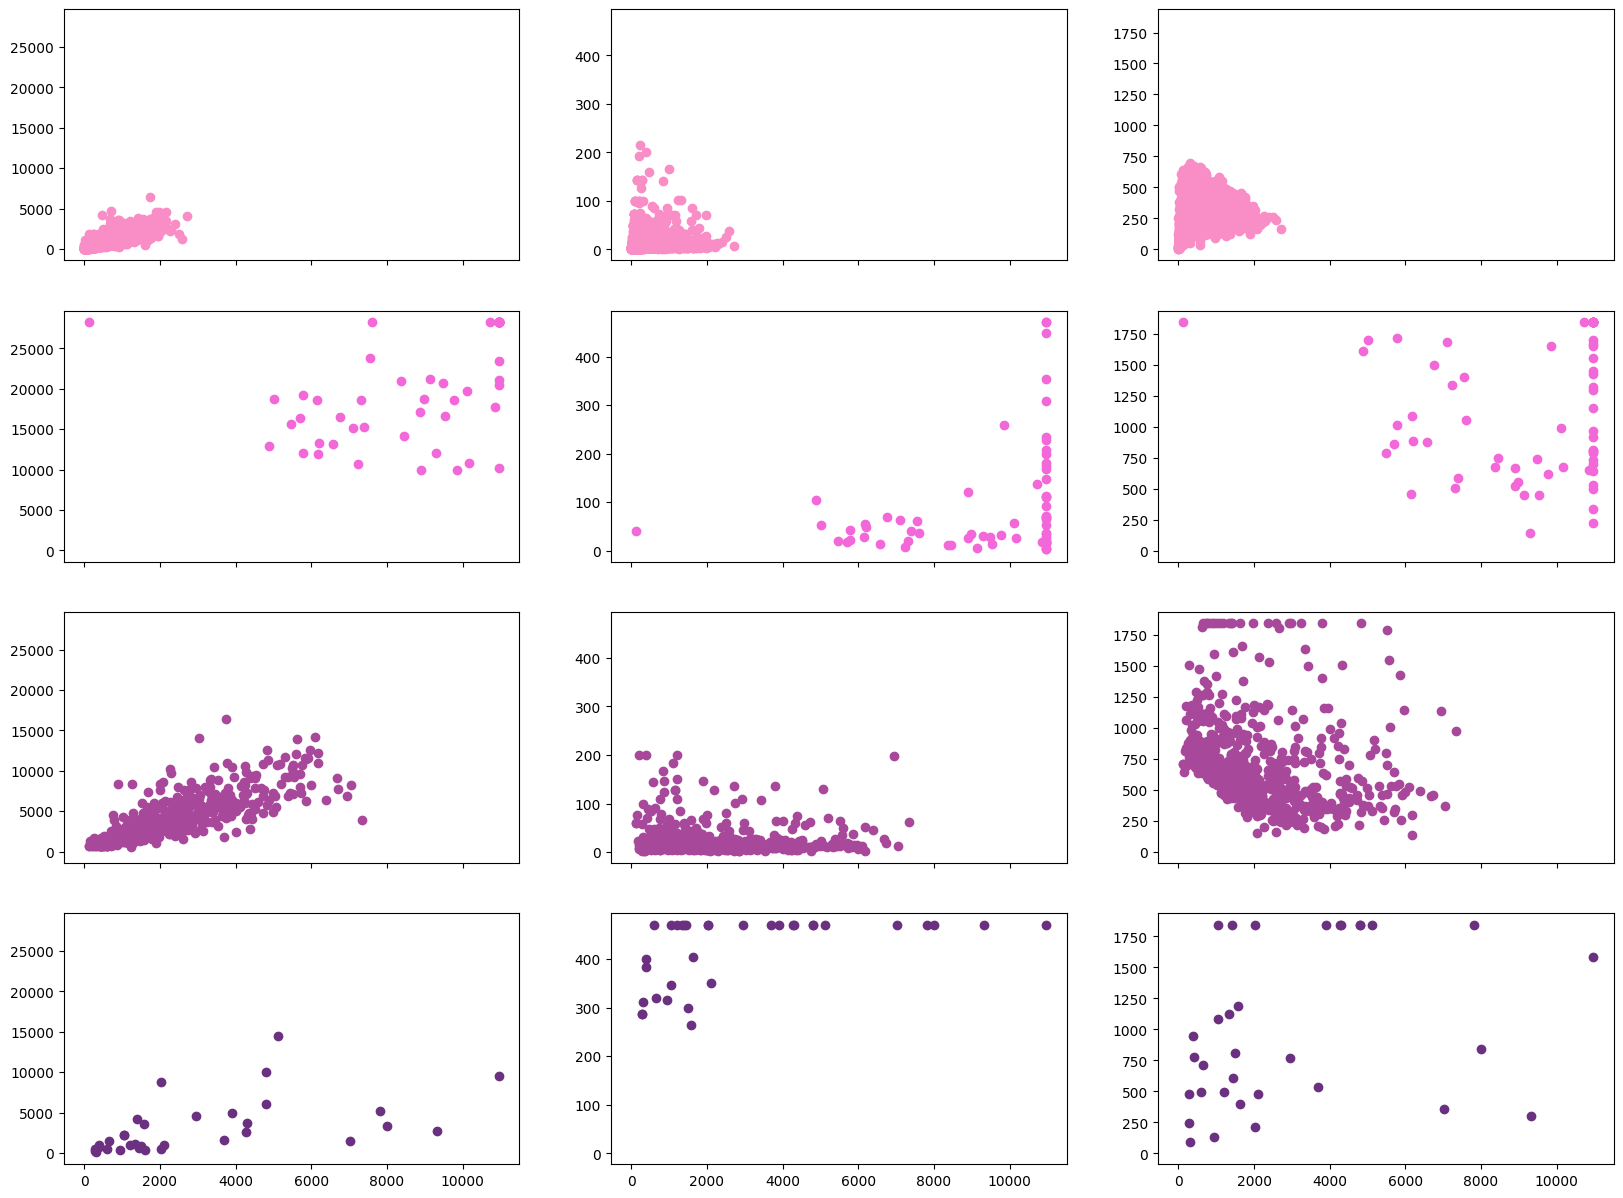

In [58]:
# Making a plots for each label
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,15), sharex='col', sharey='col')
colours = ['#F98DC6', '#F368D9', '#A7489B', '#6B307F']

for i in range(4):
    ax[i,0].scatter(x=cust_clust[cust_clust.Labels == i].TotalQuantity, y=cust_clust[cust_clust.Labels == i].TotalValue,c=colours[i])
    ax[i,1].scatter(x=cust_clust[cust_clust.Labels == i].TotalQuantity, y=cust_clust[cust_clust.Labels == i].AvrgQuantity,c=colours[i])
    ax[i,2].scatter(x=cust_clust[cust_clust.Labels == i].TotalQuantity, y=cust_clust[cust_clust.Labels == i].AvrgOrderValue,c=colours[i])
    

plt.show()